## Connection Settings

In [51]:
# load dependencies

import pandas as pd
import numpy as np
from neo4j import GraphDatabase
import plotly.express as px

In [2]:
# connection class setting

class Neo4jConnection:
    
    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)
    
    def close(self):
        if self.__driver is not None:
            self.__driver.close()
        
    def query(self, query, parameters=None, db=None):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session() 
            response = list(session.run(query, parameters))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response

# execute connection
con = Neo4jConnection("bolt://neo4j:7687", user="neo4j", pwd="1234")

## Unique Owner

### Number of Count by Owner

In [77]:
query_unique_owner = '''
    MATCH (r:Repository)
    RETURN DISTINCT r.owner, count(r)
    ORDER BY count(r) DESC
'''

q_unique_owner = con.query(query_unique_owner, db = 'mlgit')
df_unique_owner = pd.DataFrame([dict(_) for _ in q_unique_owner]).rename(columns = {'r.owner':'Owner','count(r)':'Count'})
df_unique_owner.head(20)

,Owner,Count
0,Alphabet,48
1,Microsoft,43
2,Facebook,33
3,FOSSASIA,31
4,TensorFlow,28
5,NVIDIA,19
6,Intel,18
7,Amazon,13
8,Tencent,11
9,aio-libs,9


In [78]:
print('N of unique owner : ', len(df_unique_owner))

N of unique owner :  536


## InDegree
list of most connected repos

In [5]:
query_repo_indegree = '''
    MATCH ()-[:SIMILAR]-(r:Repository)
    RETURN r.id, r.owner, r.name, count(*) as InDegree
    ORDER BY InDegree DESC
'''

q_repo_indegree = con.query(query_repo_indegree, db = 'mlgit')
df_repo_indegree = (pd
                    .DataFrame([dict(_) for _ in q_repo_indegree])
                    .rename(columns = {'r.id':'NodeID',
                                      'r.owner':'Owner',
                                      'r.name':'RepoName'}))

# InDegree by repo
df_repo_indegree.head(20)

,NodeID,Owner,RepoName,InDegree
0,1366,Sony,nnabla,37
1,2189,Dive into Deep Learning,d2l-zh,23
2,1669,FOSSASIA,susi.ai,22
3,2193,Datawhale,key-book,22
4,2200,O'Reilly Japan,deep-learning-from-scratch,22
5,1811,Microsoft,tf-gnn-samples,21
6,570,Apache China,home,19
7,1656,FOSSASIA,susi_api_wrapper,19
8,1659,FOSSASIA,susi_iOS,19
9,1667,FOSSASIA,susi_smart_box,19


In [6]:
df_repo_indegree.shape

(665, 4)

In [7]:
# InDegree by owner

df_owner_indegree = (df_repo_indegree
                        .groupby(['Owner'])['InDegree']
                        .sum()
                        .reset_index()
                        .sort_values(by='InDegree', ascending = False)
                        .head(20))
df_owner_indegree

,Owner,InDegree
88,FOSSASIA,349
160,Microsoft,111
17,Alphabet,98
89,Facebook,76
201,PaddlePaddle,74
253,TensorFlow,74
68,Datawhale,55
19,Amazon,46
22,Apache China,40
240,Sony,37


## Centrality : PageRank

In [8]:
# gds graph name prep for node centrality
query_gds_graph = '''
    CALL gds.graph.create(
        'mlgitGraph',
        'Repository',
        'SIMILAR',
        {
            relationshipProperties: 'weight'
        }
    )
'''

con.query(query_gds_graph, db = 'mlgit')

[<Record nodeProjection={'Repository': {'properties': {}, 'label': 'Repository'}} relationshipProjection={'SIMILAR': {'orientation': 'NATURAL', 'aggregation': 'DEFAULT', 'type': 'SIMILAR', 'properties': {'weight': {'property': 'weight', 'aggregation': 'DEFAULT', 'defaultValue': None}}}} graphName='mlgitGraph' nodeCount=989 relationshipCount=1208 createMillis=46>]

In [9]:
# gds centrality (pagerank) of similarity write
query_pagerank_write = '''
    CALL gds.pageRank.write('mlgitGraph',{
        writeProperty: 'pagerank'
    })
    YIELD nodePropertiesWritten, ranIterations
'''

con.query(query_pagerank_write, db = 'mlgit')

[<Record nodePropertiesWritten=989 ranIterations=15>]

In [10]:
# pull pagerank centrality result
query_pagerank_pull = '''
    MATCH (r:Repository)
    RETURN DISTINCT r.id, r.owner, r.name, r.pagerank
    ORDER BY r.pagerank DESC
'''

df_repo_pagerank = (pd
                    .DataFrame([dict(_) for _ in con.query(query_pagerank_pull, db = 'mlgit')])
                    .rename(columns = {'r.id':'NodeID',
                                      'r.owner':'Owner',
                                      'r.name':'RepoName',
                                      'r.pagerank':'PageRank'}))

# pagerank by repo
df_repo_pagerank.head(20)

,NodeID,Owner,RepoName,PageRank
0,1811,Microsoft,tf-gnn-samples,2.853313
1,1366,Sony,nnabla,2.690252
2,2037,FOSSASIA,susi_viberbot,2.620624
3,1819,Alphabet,sonnet,1.771548
4,1831,hasktorch,hasktorch,1.477750
5,2337,Machine Learning Tooling,ml-workspace,1.461412
6,1999,FOSSASIA,susi_tweetbot,1.403122
7,2164,scikit-learn,scikit-learn,1.392838
8,2036,Replicate.ai,keepsake,1.377348
9,1884,fast.ai,fastai,1.349693


In [11]:
# pagerank by owner

df_owner_pagerank = (df_repo_pagerank
                      .groupby(['Owner'])['PageRank']
                      .sum()
                      .reset_index()
                      .sort_values(by = 'PageRank', ascending = False)
                      .head(20))
df_owner_pagerank

,Owner,PageRank
244,Microsoft,15.659560
131,FOSSASIA,14.150417
31,Alphabet,11.184247
132,Facebook,8.080870
377,TensorFlow,7.264442
458,fast.ai,4.758368
260,NVIDIA,4.599322
183,Intel,3.614522
33,Amazon,3.547098
96,Datawhale,2.723142


## Centrality : Betweenness

In [12]:
# gds centrality (betweenness) of similarity write
query_betweenness_write = '''
    CALL gds.betweenness.write('mlgitGraph',{
        writeProperty: 'betweenness'
    })
    YIELD minimumScore, maximumScore, scoreSum, nodePropertiesWritten
'''

con.query(query_betweenness_write, db = 'mlgit')

[<Record minimumScore=0.0 maximumScore=1197.6666666666667 scoreSum=8460.0 nodePropertiesWritten=989>]

In [13]:
# pull betweenness centrality result
query_betweenness_pull = '''
    MATCH (r:Repository)
    RETURN DISTINCT r.id, r.owner, r.name, r.betweenness
    ORDER BY r.betweenness DESC
'''

df_repo_betweenness = (pd
                      .DataFrame([dict(_) for _ in con.query(query_betweenness_pull, db = 'mlgit')])
                      .rename(columns = {'r.id':'NodeID',
                                      'r.owner':'Owner',
                                      'r.name':'RepoName',
                                      'r.betweenness':'Betweenness'}))

# betweenness by repo
df_repo_betweenness.head(20)

,NodeID,Owner,RepoName,Betweenness
0,1366,Sony,nnabla,1197.666667
1,820,Keras-RL,keras-rl,531.500000
2,1214,Lasagne,Lasagne,498.000000
3,1170,Keras (MIT),keras-contrib,263.500000
4,885,Horovod,horovod,235.000000
5,806,Keras (MIT),keras,232.000000
6,882,"University of California, Berkeley",SparkNet,211.333333
7,1425,kornia,kornia,205.333333
8,1035,Alphabet,google-research,196.000000
9,1428,OpenNMT,OpenNMT-py,192.500000


In [14]:
# betweenness by owner

df_owner_betweenness = (df_repo_betweenness
                       .groupby(['Owner'])['Betweenness']
                       .sum()
                       .reset_index()
                       .sort_values(by = 'Betweenness', ascending = False)
                       .head(20))
df_owner_betweenness

,Owner,Betweenness
361,Sony,1197.666667
197,Keras (MIT),671.500000
131,FOSSASIA,550.000000
244,Microsoft,535.500000
198,Keras-RL,531.500000
206,Lasagne,498.000000
31,Alphabet,367.500000
282,Open Neural Network Exchange,244.500000
166,Horovod,235.000000
404,"University of California, Berkeley",211.333333


## Ensemble Scoring for Influence in AI Market

In [34]:
# pull all scoring
query_ensemble = '''
    MATCH (r:Repository)
    RETURN DISTINCT r.id, r.owner, r.name, r.star, r.fork, r.watcher, r.pagerank, r.betweenness
    ORDER BY r.pagerank DESC
'''

q_repo_ensemble = con.query(query_ensemble, db = 'mlgit')
df_repo_ensemble = (pd
                   .DataFrame([dict(_) for _ in q_repo_ensemble])
                   .rename(columns = {'r.id':'NodeID',
                                     'r.owner':'Owner',
                                     'r.name':'RepoName',
                                     'r.star':'StarNorm',
                                     'r.fork':'ForkNorm',
                                     'r.watcher':'WatcherNorm',
                                     'r.pagerank':'PageRank',
                                     'r.betweenness':'Betweenness'}))

# InDegree df prep
df_repo_indegree_join = df_repo_indegree[['NodeID','InDegree']]

# ensemble by repo
df_repo_ensemble = pd.merge(df_repo_ensemble,df_repo_indegree_join,on='NodeID')

In [48]:
# normalize function
def df_norm(df,col):
    # normalize data frame columns
    return (df[col]-df[col].min())/(df[col].max()-df[col].min())

df_repo_ensemble['PageRankNorm'] = df_norm(df_repo_ensemble,'PageRank')
df_repo_ensemble['BetweennessNorm'] = df_norm(df_repo_ensemble, 'Betweenness')
df_repo_ensemble['InDegreeNorm'] = df_norm(df_repo_ensemble, 'InDegree')
df_repo_ensemble_norm = df_repo_ensemble.drop(columns = ['PageRank','Betweenness','InDegree'])

In [54]:
# create ensemble columns (average from each Norm columns)
df_repo_ensemble_norm['Influence_Score'] = df_repo_ensemble_norm[['StarNorm','ForkNorm','WatcherNorm',
                                                                  'PageRankNorm','BetweennessNorm','InDegreeNorm']].mean(axis=1)

# concatenate Owner and RepoName for plot
df_repo_ensemble_norm['Owner_Repo'] = df_repo_ensemble_norm['Owner'] + '/' + df_repo_ensemble_norm['RepoName']

# top 20 data frame
df_repo_influence = (df_repo_ensemble_norm
 .sort_values(by = 'Influence_Score', ascending = False)
 .head(20))
df_repo_influence

,NodeID,Owner,RepoName,StarNorm,ForkNorm,WatcherNorm,PageRankNorm,BetweennessNorm,InDegreeNorm,Influence_Score,Owner_Repo
1,1366,Sony,nnabla,0.461824,0.420362,0.517064,0.939681,1.000000,1.000000,0.723155,Sony/nnabla
7,2164,scikit-learn,scikit-learn,1.000000,1.000000,1.000000,0.459746,0.017534,0.333333,0.635102,scikit-learn/scikit-learn
62,2189,Dive into Deep Learning,d2l-zh,0.999910,0.982293,0.992450,0.156091,0.026289,0.611111,0.628024,Dive into Deep Learning/d2l-zh
61,1035,Alphabet,google-research,0.995560,0.904793,0.956689,0.157951,0.163652,0.416667,0.599219,Alphabet/google-research
134,806,Keras (MIT),keras,1.000000,1.000000,1.000000,0.084542,0.193710,0.305556,0.597301,Keras (MIT)/keras
291,523,TensorFlow,tensorflow,1.000000,1.000000,1.000000,0.027513,0.080573,0.361111,0.578199,TensorFlow/tensorflow
9,1884,fast.ai,fastai,0.999175,0.994714,0.942351,0.443786,0.000000,0.027778,0.567967,fast.ai/fastai
67,1423,OpenCV,opencv,1.000000,1.000000,1.000000,0.148611,0.000000,0.194444,0.557176,OpenCV/opencv
88,2197,nndl,nndl.github.io,0.977181,0.841445,0.976751,0.123737,0.001908,0.416667,0.556282,nndl/nndl.github.io
24,1684,Distributed Machine Learning Community,xgboost,0.999235,0.998480,0.995830,0.255182,0.000000,0.083333,0.555344,Distributed Machine Learning Community/xgboost


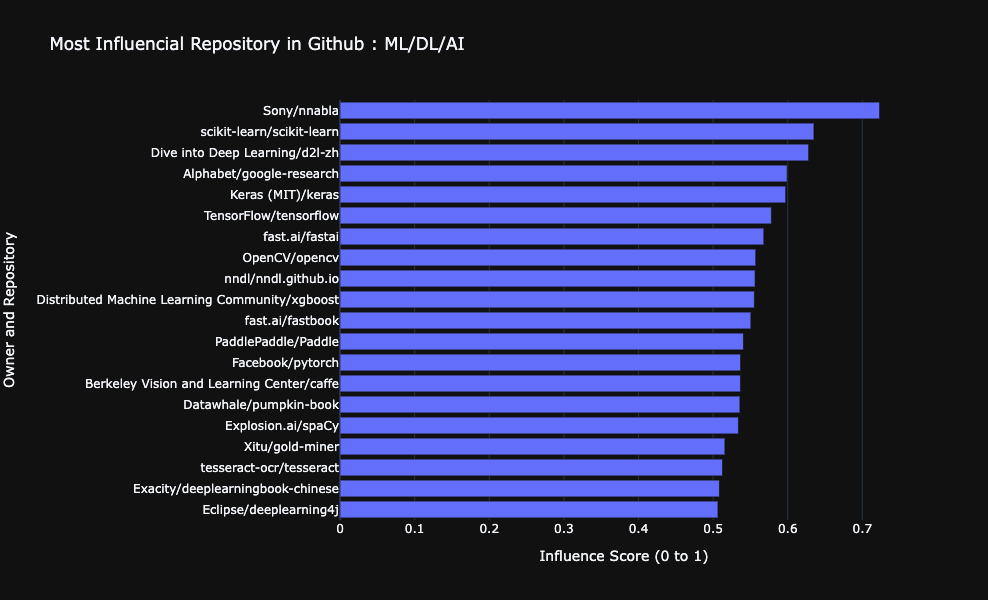

In [92]:
# vertical bar chart for top 20 repo
fig = px.bar(df_repo_influence.sort_values(by = 'Influence_Score', ascending = True),
            x='Influence_Score',
            y='Owner_Repo',
            orientation='h',
            title='Most Influencial Repository in Github : ML/DL/AI',
            height = 600,
            template = 'plotly_dark')
fig.update_yaxes(title = 'Owner and Repository')
fig.update_xaxes(title = 'Influence Score (0 to 1)')
fig.show()

In [79]:
df_unique_owner['CountNorm'] = df_norm(df_unique_owner, 'Count')
df_unique_owner = df_unique_owner.drop(columns = ['Count'])
df_unique_owner.head(10)

,Owner,CountNorm
0,Alphabet,1.000000
1,Microsoft,0.893617
2,Facebook,0.680851
3,FOSSASIA,0.638298
4,TensorFlow,0.574468
5,NVIDIA,0.382979
6,Intel,0.361702
7,Amazon,0.255319
8,Tencent,0.212766
9,aio-libs,0.170213


In [86]:
# group by for owner summation

df_owner_influence = (df_repo_ensemble_norm
                     .groupby(['Owner'])
                     .mean()
                     .reset_index()
                     .sort_values(by = 'Influence_Score', ascending = False))

# add count
df_owner_influence = pd.merge(df_owner_influence, df_unique_owner, on='Owner').drop(columns = ['Influence_Score'])

# create ensemble for owner score
df_owner_influence['Influence_Score'] = df_owner_influence[['StarNorm','ForkNorm','WatcherNorm','PageRankNorm',
#                                                             'BetweennessNorm','InDegreeNorm',
                                                            'CountNorm']].mean(axis=1)


df_owner_influence = (df_owner_influence
                     .sort_values(by = 'Influence_Score', ascending = False)
                     .drop(columns = ['NodeID'])
                     .head(20))
df_owner_influence

,Owner,StarNorm,ForkNorm,WatcherNorm,PageRankNorm,BetweennessNorm,InDegreeNorm,CountNorm,Influence_Score
1,scikit-learn,1.000000,1.000000,1.000000,0.459746,0.017534,0.333333,0.000000,0.691949
2,OpenCV,1.000000,1.000000,1.000000,0.148611,0.000000,0.194444,0.000000,0.629722
6,tesseract-ocr,1.000000,0.996284,1.000000,0.079459,0.000000,0.000000,0.000000,0.615149
4,Berkeley Vision and Learning Center,1.000000,1.000000,1.000000,0.005879,0.075424,0.138889,0.000000,0.601176
7,JuliaLang,1.000000,0.933726,0.996962,0.015721,0.000000,0.000000,0.000000,0.589282
3,nndl,0.977181,0.841445,0.976751,0.123737,0.001908,0.416667,0.000000,0.583823
8,oxford-cs-deepnlp-2017,0.981938,0.875386,0.999861,0.000000,0.000000,0.027778,0.000000,0.571437
5,Dive into Deep Learning,0.946423,0.860524,0.853678,0.147045,0.016902,0.361111,0.021277,0.565789
12,RARE Technologies,0.945063,0.906650,0.825768,0.023582,0.000000,0.000000,0.000000,0.540213
13,The Algorithms,0.918981,0.825827,0.843823,0.023582,0.000417,0.013889,0.021277,0.526698


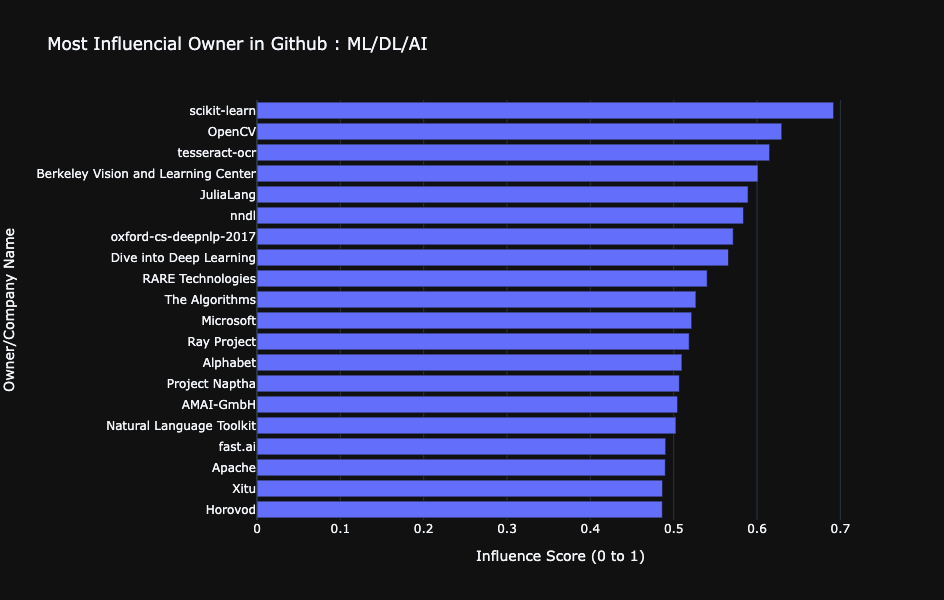

In [87]:
# vertical bar chart for top 20 owner
fig = px.bar(df_owner_influence.sort_values(by = 'Influence_Score', ascending = True),
            x='Influence_Score',
            y='Owner',
            orientation='h',
            title='Most Influencial Owner in Github : ML/DL/AI',
            height = 600,
            template = 'plotly_dark')
fig.update_yaxes(title = 'Owner/Company Name')
fig.update_xaxes(title = 'Influence Score (0 to 1)')
fig.show()